## Fit final model with OOT
---

We have observed data cleaning did not lead to degrading model performance. From now on the model refers to the cleaned version.

In [1]:
import os, sys, json
import pickle as pkl
import pandas as pd

import lightgbm as lgb
from rdsutils import datagen
import rdsutils.plot as rdsplot
from utils import preprocess

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
modeling_df = pd.read_parquet('../../artifacts/final/modeling_df_w_preds.parquet')
test_df = pd.read_parquet('../../artifacts/final/test_df_w_baselines.parquet')
modeling_df.shape, test_df.shape

((112599, 241), (152951, 236))

In [3]:
modeling_df = modeling_df.copy()
modeling_df = preprocess(modeling_df)

test_df = test_df.copy()
test_df = preprocess(test_df)

In [4]:
seed = 12345
target_col = 'ach_target'

In [5]:
display(modeling_df[target_col].value_counts(), 
        test_df[target_col].value_counts())

False    108825
True       3774
Name: ach_target, dtype: int64

False    145410
True       7541
Name: ach_target, dtype: int64

### Fit full model
---

In [6]:
features = pkl.load(open('../../artifacts/final/features_corr_removed.pkl', 'rb'))
with open('../../artifacts/final/final_params_cleaned.json', 'r') as f:
    params = json.load(f)
params['early_stopping_round'] = None
params

{'num_boost_round': 215,
 'num_threads': 16,
 'objective': 'binary',
 'verbose': -1,
 'boosting_type': 'gbdt',
 'two_round': True,
 'metric': 'auc',
 'boosting': 'gbdt',
 'tree_learner': 'feature',
 'boost_from_average': 'false',
 'num_leaves': 52,
 'lambda_l1': 30.0,
 'lambda_l2': 50.0,
 'min_data_in_leaf': 121,
 'max_depth': 5,
 'learning_rate': 0.1,
 'feature_fraction': 0.8,
 'scale_pos_weight': 28.835453100158983,
 'early_stopping_round': None,
 'seed': 12345,
 'seed_value': 12345}

In [7]:
clf = lgb.LGBMClassifier(**params)
X = modeling_df[features]
y = modeling_df[target_col]

In [8]:
clf.fit(X, y)

[LightGBM] [Warning] Unknown parameter: seed_value
[LightGBM] [Warning] lambda_l1 is set=30.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.0
[LightGBM] [Warning] num_threads is set=16, n_jobs=-1 will be ignored. Current value: num_threads=16
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] num_iterations is set=215, num_boost_round=215 will be ignored. Current value: num_iterations=215


LGBMClassifier(boost_from_average='false', boosting='gbdt',
               early_stopping_round=None, feature_fraction=0.8, lambda_l1=30.0,
               lambda_l2=50.0, max_depth=5, metric='auc', min_data_in_leaf=121,
               num_boost_round=215, num_leaves=52, num_threads=16,
               objective='binary', scale_pos_weight=28.835453100158983,
               seed=12345, seed_value=12345, tree_learner='feature',
               two_round=True, verbose=-1)

In [9]:
# get OOT preds
test_df['ach_pred_cleaned'] = clf.predict_proba(test_df[features])[:,1]
test_df['pred'] = test_df['ach_pred_cleaned'] 

(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

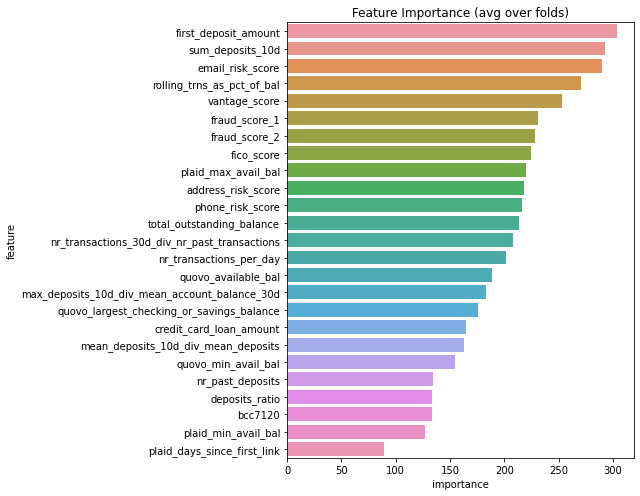

In [10]:
# feature importance
rdsplot.display_feature_importance(clf.feature_name_, 
                                   clf.feature_importances_,
                                   max_n_features=-1)

In [11]:
with open(f'../../models/ach-model.pkl', 'wb') as f:
        pkl.dump(clf, f)

### Model with Constraints

In [12]:
features = pkl.load(open('../../artifacts/final/features_corr_removed.pkl', 'rb'))
with open('../../artifacts/final/final_params_cleaned.json', 'r') as f:
    params = json.load(f)
params['early_stopping_round'] = None


pos = ['email_risk_score', 'fraud_score_1', 'phone_risk_score', 'fraud_score_2', 'address_risk_score']
pos_candidates = ['deposits_ratio', 'nr_transactions_per_day', 'total_outstanding_balance', 'rolling_trns_as_pct_of_bal', 
                  'sum_deposits_10d', 'max_deposits_10d_div_mean_account_balance_30d', 'nr_transactions_30d_div_nr_past_transactions']
neg = ['vantage_score', 'fico_score', 'bcc7120', 'nr_past_deposits']
neg_candidates = ['first_deposit_amount', 'mean_deposits_10d_div_mean_deposits', 'credit_card_loan_amount',
                  'quovo_available_bal', 'plaid_max_avail_bal', 'quovo_min_avail_bal', 'quovo_largest_checking_or_savings_balance',
                  'total_tradelines_open', 'plaid_min_avail_bal', 'plaid_days_since_first_link']
def get_monotone_constraints(features, pos, neg):
    result = []
    for f in features:
        if f in pos:
            result.append(1)
        elif f in neg:
            result.append(-1)
        else:
            result.append(0)
    return result
params['monotone_constraints'] = get_monotone_constraints(features, pos+pos_candidates, neg+neg_candidates)
params['mc_method'] = 'advanced'

In [13]:
clf = lgb.LGBMClassifier(**params)
X = modeling_df[features]
y = modeling_df[target_col]
clf.fit(X, y)

[LightGBM] [Warning] Unknown parameter: seed_value
[LightGBM] [Warning] num_iterations is set=215, num_boost_round=215 will be ignored. Current value: num_iterations=215
[LightGBM] [Warning] lambda_l1 is set=30.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30.0
[LightGBM] [Warning] num_threads is set=16, n_jobs=-1 will be ignored. Current value: num_threads=16
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


LGBMClassifier(boost_from_average='false', boosting='gbdt',
               early_stopping_round=None, feature_fraction=0.8, lambda_l1=30.0,
               lambda_l2=50.0, max_depth=5, mc_method='advanced', metric='auc',
               min_data_in_leaf=121,
               monotone_constraints=[-1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1,
                                     -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1,
                                     -1, 1],
               num_boost_round=215, num_leaves=52, num_threads=16,
               objective='binary', scale_pos_weight=28.835453100158983,
               seed=12345, seed_value=12345, tree_learner='feature',
               two_round=True, verbose=-1)

In [14]:
# get OOT preds
test_df['ach_pred_constrainted'] = clf.predict_proba(test_df[features])[:,1]

(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

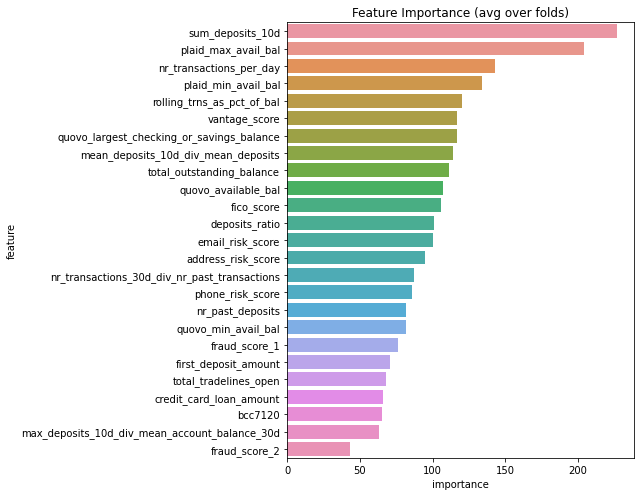

In [15]:
# feature importance
rdsplot.display_feature_importance(clf.feature_name_, 
                                   clf.feature_importances_,
                                   max_n_features=-1)

In [16]:
with open(f'../../models/ach-model-constrained.pkl', 'wb') as f:
    pkl.dump(clf, f)

### OOT Comparisons
---

In [17]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult, plot_feature_over_time

plt.style.use('seaborn')

def get_binary_metrics(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score
    from scikitplot.helpers import binary_ks_curve
    
    auc = round(roc_auc_score(y_true=y_true,
                              y_score=y_pred)*100, 2)
    ap = round(average_precision_score(y_true=y_true,
                                       y_score=y_pred)*100, 2)
    _, _, _, ks, _, _ = binary_ks_curve(y_true=y_true, y_probas=y_pred)
    ks = round(ks*100, 2) 
    
    metrics = {'auc': auc,
               'ap': ap,
               'ks': ks}

    return metrics


def get_pred_reports(df, target_col, pred_cols):
    import pandas as pd
    result = {}
    for col in pred_cols:
        metrics = get_binary_metrics(df[target_col], df[col])
        result[col] = metrics
    return pd.DataFrame(result).T

In [18]:
metrics = get_pred_reports(test_df, target_col, 
                           ['deposit_v1_pred', 
                            'customer_pred',
                            'ach_pred_cleaned',
                            'ach_pred_constrainted'])
metrics

,auc,ap,ks
deposit_v1_pred,83.61,29.14,53.76
customer_pred,88.94,49.57,63.28
ach_pred_cleaned,93.19,67.07,72.49
ach_pred_constrainted,92.60,62.82,70.80


(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'Precision-Recall curve: Baseline Comparison'}, xlabel='Recall', ylabel='Precision'>)

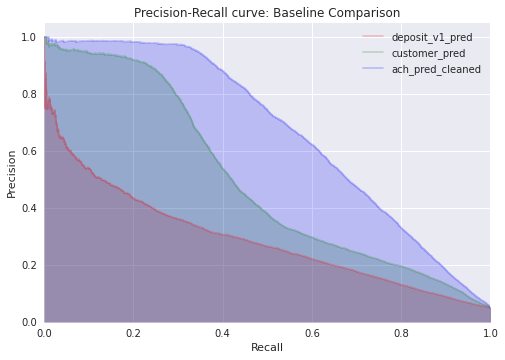

In [19]:
preds = [(test_df['deposit_v1_pred'], 'deposit_v1_pred'), 
         (test_df['customer_pred'], 'customer_pred'),
         (test_df['ach_pred_cleaned'], 'ach_pred_cleaned'),
#          (test_df['ach_pred_constrainted'], 'ach_pred_constrainted')
        ]
title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(test_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b']) 

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

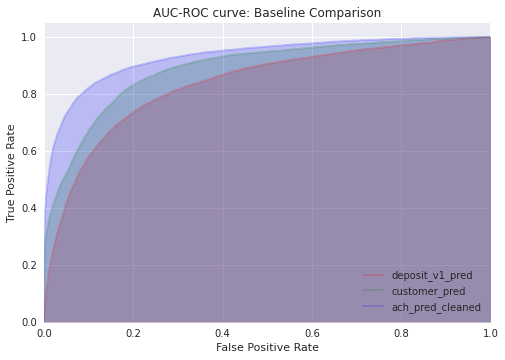

In [20]:
title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(test_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'])

### Save Data
---

In [21]:
test_df.to_parquet('../../artifacts/final/test_df_w_preds.parquet')

In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_shap_dependence(df, shap_values, features, ncols=6, figsize=None, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for feature, ax in zip(features, axs.flatten()):
        shap.dependence_plot(feature, shap_values, df, 
                             ax=ax, show=False, **kwargs)
        rlim = df[feature].quantile(0.98)
        llim = df[feature].quantile(0.02) - ((rlim - df[feature].quantile(0.02)) / 12)
            
        if rlim < np.inf and llim > -np.inf:
            ax.set_xlim(left=llim, right=rlim)
        
    return fig

In [23]:
with open(f'../../models/ach-model.pkl', 'rb') as f:
    model = pkl.load(f)

In [24]:
fimp = sorted(zip(model.feature_importances_, model.feature_name_), reverse=True)
features_by_imp = list(list(zip(*fimp))[1])

In [25]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(modeling_df[model.feature_name_])

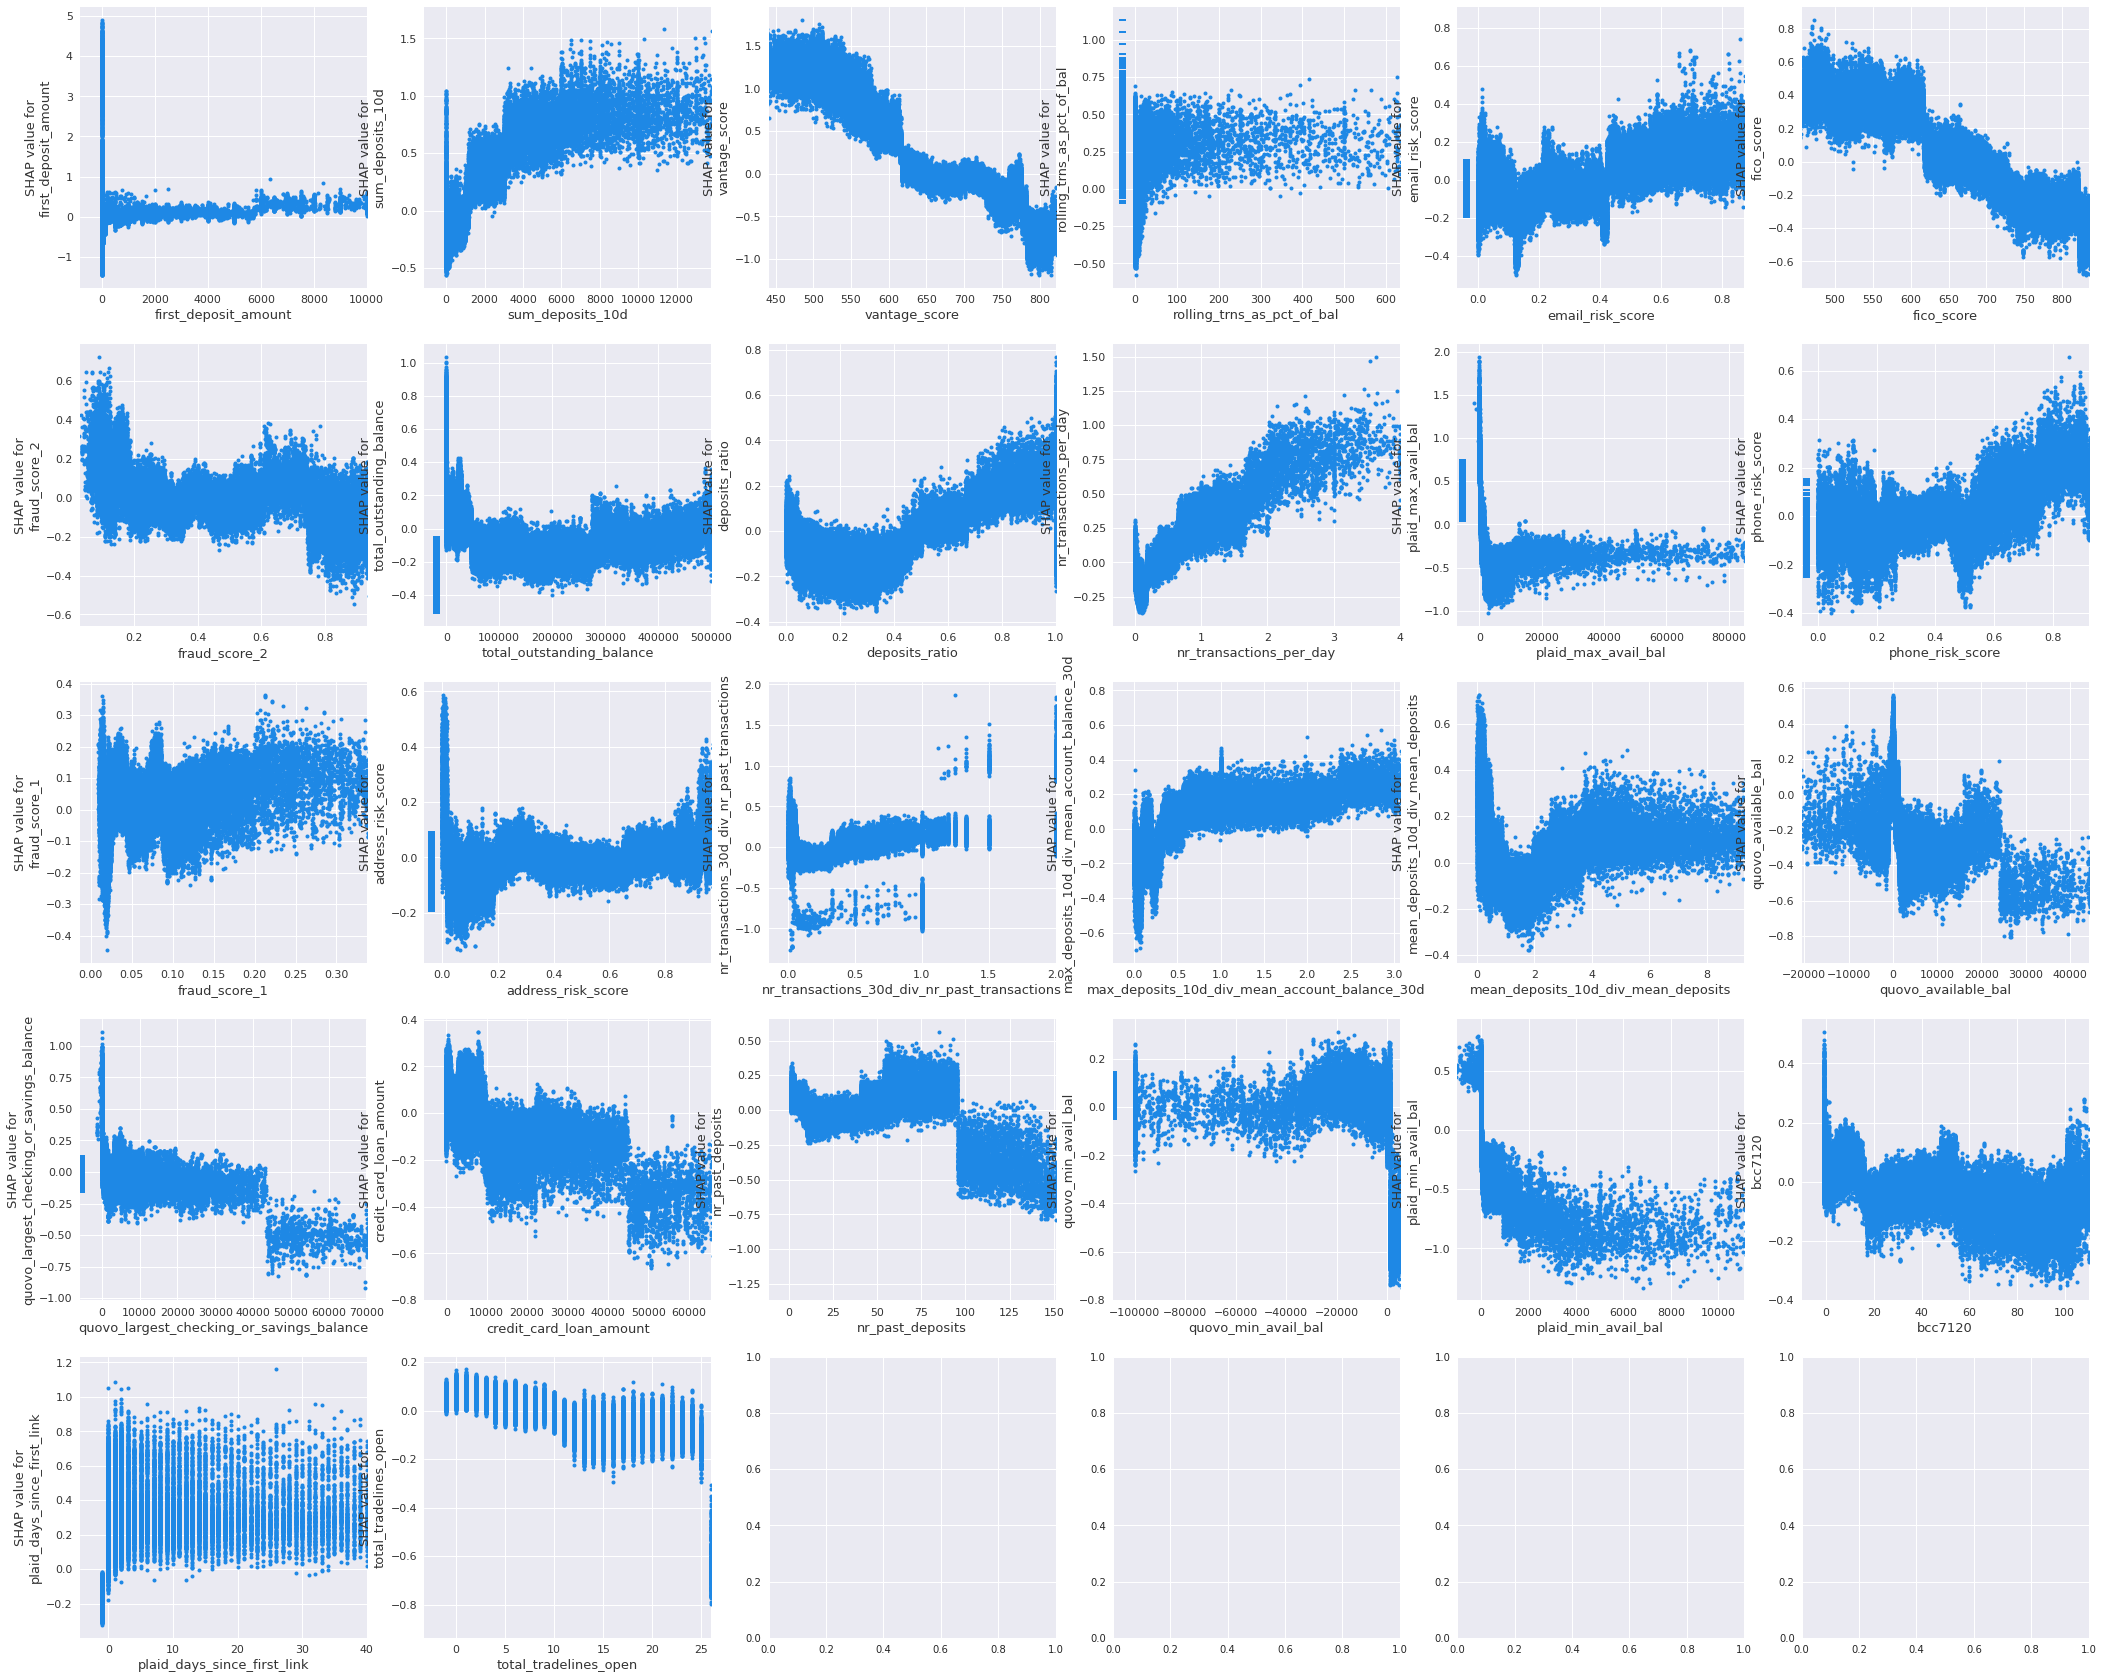

In [26]:
fig = get_shap_dependence(modeling_df[model.feature_name_], 
                          shap_values[1], features_by_imp, interaction_index=None)

In [27]:
fig.savefig('../../artifacts/final/plots/shap_value_top_18_ach_constrainted_adv.png')